In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cftime
#import cmaps
import cartopy
import cartopy.crs as ccrs
#import sectionate
import intake
#!conda install -c conda-forge xmip
import xmip.preprocessing as xmip
#from xmip.preprocessing import rename_cmip6

from util import * 

from __future__ import print_function
import requests
import xml.etree.ElementTree as ET

import warnings

warnings.filterwarnings('ignore')

xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [69]:
## Currently this all runs using files on esgf
# Eventually data will be loaded in from zarr files
# So will want to 

In [2]:
## Load in file of model names and fnames
model_fnames_dict = np.load("../models.npy", allow_pickle=True).item()
models_fnames_dict_depth = np.load("../models_depth.npy", allow_pickle=True).item()

In [44]:
#66 + (19.6/60) - 0.5 - 65.6922817256617


In [3]:
### Set Bering Straight region 

bering_minlon = 190 #188 #172 #160
bering_maxlon = 192 #196 #200
#Note that most models are very sensitive to the maxlon value as most of the grids slant that way


lat_bs_i = 66 + (19.6/60) - 0.65 #0.5

bs_lons = [bering_minlon, bering_maxlon]
bs_lats = [lat_bs_i, lat_bs_i]

In [4]:
dsnow = load_ds_from_esgf_file_in_model_fnames_dict(list(model_fnames_dict.keys())[0], model_fnames_dict, flg_onefile=False)
dsnow

<xarray.Dataset>
Dimensions:        (time: 732, lev: 50, y: 72, x: 360, bnds: 2, vertex: 4)
Coordinates:
  * time           (time) object 1958-01-16 12:00:00 ... 2018-12-16 12:00:00
    time_bounds    (time, bnds) object dask.array<chunksize=(732, 2), meta=np.ndarray>
  * lev            (lev) float64 0.5126 1.621 2.858 ... 5.498e+03 5.904e+03
    lev_bounds     (lev, bnds) float64 dask.array<chunksize=(50, 2), meta=np.ndarray>
  * y              (y) int32 219 220 221 222 223 224 ... 285 286 287 288 289 290
  * x              (x) int32 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    lat_verticies  (y, x, vertex) float64 dask.array<chunksize=(72, 360, 4), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float64 dask.array<chunksize=(72, 360, 4), meta=np.ndarray>
    lat            (y, x) float64 dask.array<chunksize=(72, 360), meta=np.ndarray>
    lon            (y, x) float64 dask.array<chunksize=(72, 360), meta=np.ndarray>
    lon_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 72, 360), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 72, 360), meta=np.ndarray>
Dimensions without coordinates: bnds, vertex
Data variables:
    so             (time, lev, y, x) float32 dask.array<chunksize=(732, 50, 72, 360), meta=np.ndarray>
    thetao         (time, lev, y, x) float32 dask.array<chunksize=(732, 50, 72, 360), meta=np.ndarray>
    umo            (time, lev, y, x) float32 dask.array<chunksize=(732, 50, 72, 360), meta=np.ndarray>
    vmo            (time, lev, y, x) float32 dask.array<chunksize=(732, 50, 72, 360), meta=np.ndarray>
Attributes: (12/40)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     OMIP
    comment:                         Ocean initial conditions: WOA 2013 T & S...
    contact:                         Pier Giuseppe Fogli (piergiuseppe.fogli@...
    creation_date:                   2020-02-19T13:19:24Z
    data_specs_version:              01.00.31
    ...                              ...
    variable_id:                     so
    variant_label:                   r1i1p1f1
    license:                         CMIP6 model data produced by CMCC is lic...
    cmor_version:                    3.5.0
    tracking_id:                     hdl:21.14100/9d4018cc-7141-4e03-8b30-484...
    DODS_EXTRA.Unlimited_Dimension:  time

In [5]:
dsnow = load_from_esgf_file_in_model_fnames_dict(list(model_fnames_dict.keys())[0], model_fnames_dict, 'True')
dsnow

<xarray.Dataset>
Dimensions:        (time: 732, lev: 50, y: 72, x: 360, bnds: 2, vertex: 4)
Coordinates: (12/14)
  * time           (time) object 1958-01-16 12:00:00 ... 2018-12-16 12:00:00
    time_bounds    (time, bnds) object dask.array<chunksize=(732, 2), meta=np.ndarray>
  * lev            (lev) float64 0.5126 1.621 2.858 ... 5.498e+03 5.904e+03
    lev_bounds     (lev, bnds) float64 dask.array<chunksize=(50, 2), meta=np.ndarray>
  * y              (y) float64 50.65 51.34 52.02 52.69 ... 88.96 89.37 89.74
  * x              (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    ...             ...
    lat            (y, x) float64 dask.array<chunksize=(72, 360), meta=np.ndarray>
    lon            (y, x) float64 dask.array<chunksize=(72, 360), meta=np.ndarray>
  * bnds           (bnds) int64 0 1
  * vertex         (vertex) int64 0 1 2 3
    lon_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 72, 360), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 72, 360), meta=np.ndarray>
Data variables:
    so             (time, lev, y, x) float32 dask.array<chunksize=(732, 50, 72, 360), meta=np.ndarray>
Attributes: (12/40)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     OMIP
    comment:                         Ocean initial conditions: WOA 2013 T & S...
    contact:                         Pier Giuseppe Fogli (piergiuseppe.fogli@...
    creation_date:                   2020-02-19T13:19:24Z
    data_specs_version:              01.00.31
    ...                              ...
    variable_id:                     so
    variant_label:                   r1i1p1f1
    license:                         CMIP6 model data produced by CMCC is lic...
    cmor_version:                    3.5.0
    tracking_id:                     hdl:21.14100/9d4018cc-7141-4e03-8b30-484...
    DODS_EXTRA.Unlimited_Dimension:  time

In [5]:
def subset_model_by_lat_ind(dsnow_gt_bs_lat_i) : 
    #Calc all min and max x and y indexes
    yind1 = dsnow_gt_bs_lat_i.lat.isel(y=0).y.values
    yind2 = dsnow_gt_bs_lat_i.lat.isel(y=-1).y.values
    xind1 = dsnow_gt_bs_lat_i.lat.isel(x=0).x.values
    xind2 = dsnow_gt_bs_lat_i.lat.isel(x=-1).x.values

    ## Determine if x or y index corresponds to lat and if min or max index corresponds to lat

    y1_ind_diff = np.nanmax(dsnow_gt_bs_lat_i.lat.sel(y=yind1).values)-np.nanmin(dsnow_gt_bs_lat_i.lat.sel(y=yind1).values)
    y2_ind_diff = np.nanmax(dsnow_gt_bs_lat_i.lat.sel(y=yind2).values)-np.nanmin(dsnow_gt_bs_lat_i.lat.sel(y=yind2).values)

    x1_ind_diff = np.nanmax(dsnow_gt_bs_lat_i.lat.sel(x=xind1).values)-np.nanmin(dsnow_gt_bs_lat_i.lat.sel(x=xind1).values)
    x2_ind_diff = np.nanmax(dsnow_gt_bs_lat_i.lat.sel(x=xind2).values)-np.nanmin(dsnow_gt_bs_lat_i.lat.sel(x=xind2).values)

    # First test if lat range corresponding to xind or yind max-min is bigger
    if (y1_ind_diff < x1_ind_diff) & (y2_ind_diff < x2_ind_diff)  : 
        # If true then y ind corresponds to determining lat 
        # Ideally should test this for both x1 and x2 BUT should be same

        #Test if y1 or y2 corresponds to min lat
        if np.nanmin(dsnow_gt_bs_lat_i.lat.sel(y=yind1).values) <= np.nanmin(dsnow_gt_bs_lat_i.lat.sel(y=yind2).values) : 
            dsnow_bs_lat_i_ind = dsnow.sel(y=yind1) #dsnow_gt_bs_lat_i.sel(y=yind1)

        else : 
            print("y2 > y1")
            dsnow_bs_lat_i_ind = dsnow.sel(y=yind2) #dsnow_gt_bs_lat_i.sel(y=yind2)


    elif (y1_ind_diff > x1_ind_diff) & (y2_ind_diff > x2_ind_diff)  : 
        # If True then x ind corresponds to determining lat
        print('Note : x ind seems to correspond to lat not y (as expected)!')

        #Test if y1 or y2 corresponds to min lat
        if np.nanmin(dsnow_gt_bs_lat_i.lat.sel(x=xind1).values) < np.nanmin(dsnow_gt_bs_lat_i.lat.sel(x=xind2).values) : 
            dsnow_bs_lat_i_ind = dsnow.sel(x=xind1) #dsnow_gt_bs_lat_i.sel(x=xind1)

        else : 
            print("y2 > y1")
            dsnow_bs_lat_i_ind = dsnow.sel(x=xind2) #dsnow_gt_bs_lat_i.sel(x=xind2)

    else : 
        print("Something weird is going on - check what is happening. x1_ind_diff is : "+str(x1_ind_diff)+", x2_ind_diff is : "+str(x2_ind_diff)+"y1_ind_diff is : "+str(y1_ind_diff)+", y2_ind_diff is : "+str(y2_ind_diff))
        dsnow_bs_lat_i_ind = []
        
        
    return(dsnow_bs_lat_i_ind)

CMCC-CM2-SR5
NorESM2-LM
MRI-ESM2-0
CNRM-CM6-1
FGOALS-f3-L
CNRM-CM6-1-HR
TaiESM1-TIMCOM
CMCC-CM2-HR4
TaiESM1-TIMCOM2
ACCESS-OM2
EC-Earth3
ACCESS-OM2-025
MIROC6
CPU times: user 23.3 s, sys: 1.79 s, total: 25.1 s
Wall time: 1min 45s


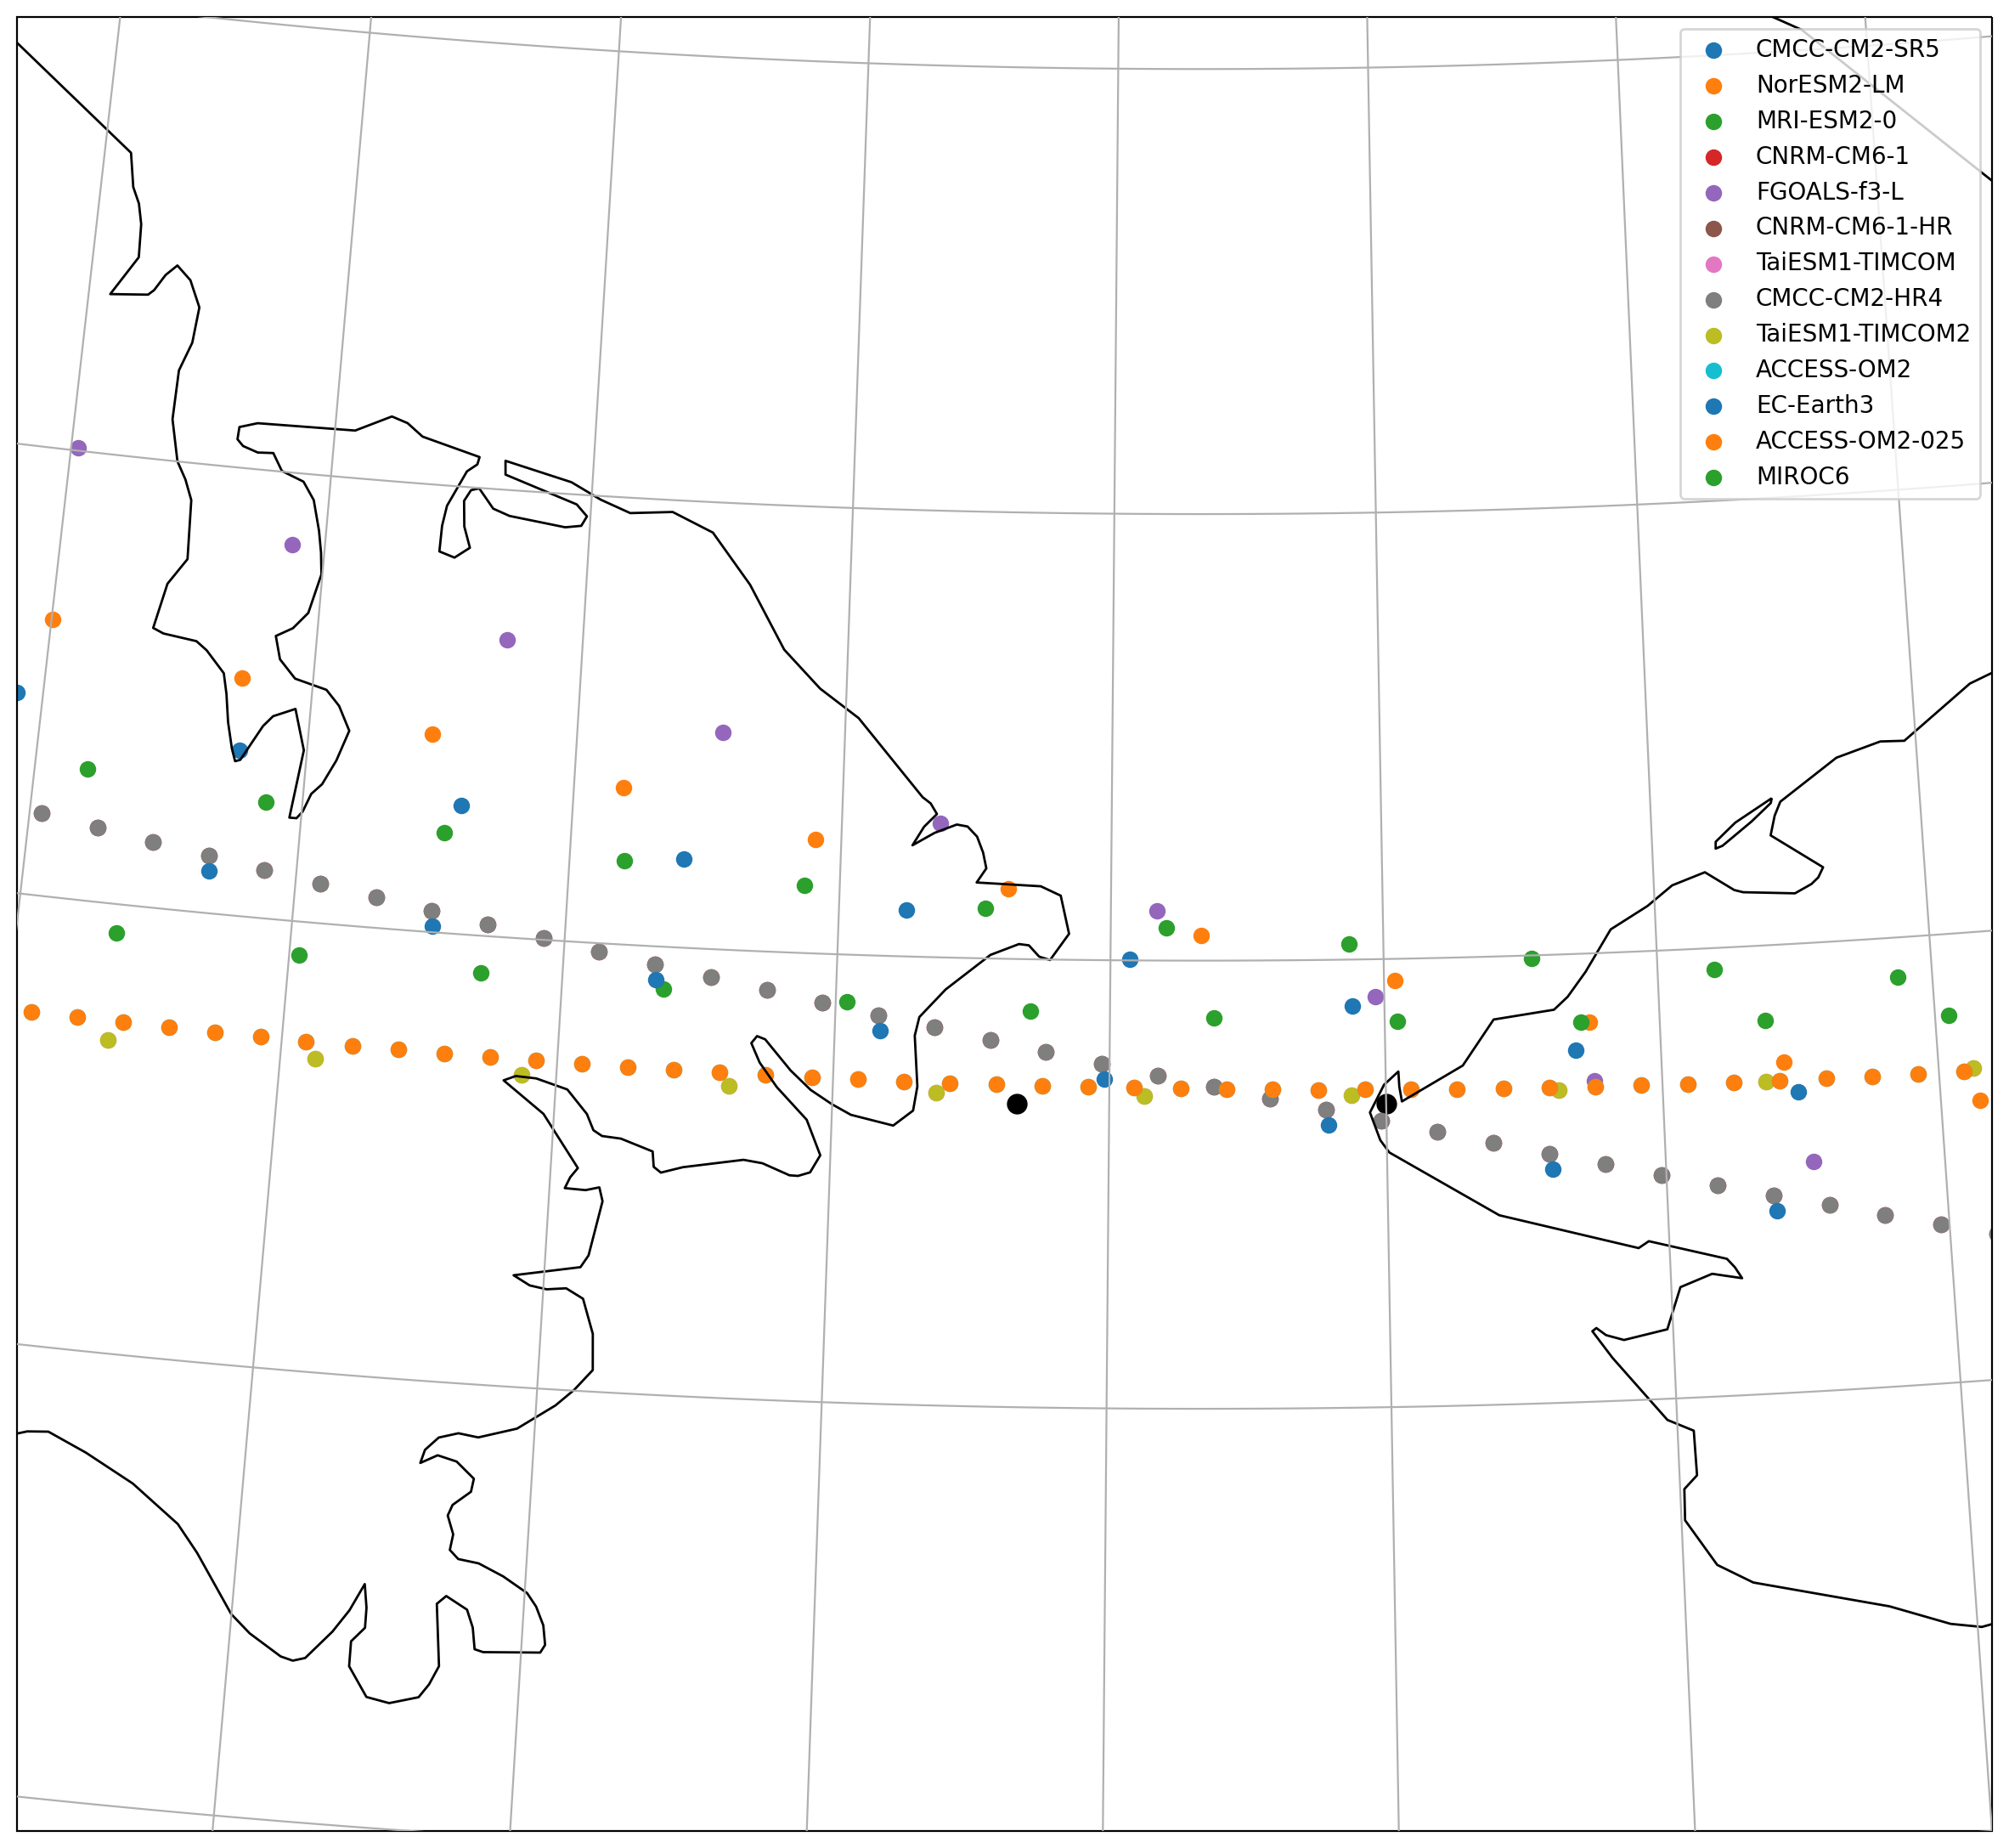

In [51]:
%%time 

## Loop through models and load in file, find lowest index then plot it

for model in model_fnames_dict : 
    print(model)

    #model = list(model_fnames_dict.keys())[0]

    try : 
        #Load dsnow using load_model_from_esgf_file_in_model_fnames_dict
        dsnow = load_ds_from_esgf_file_in_model_fnames_dict(model, model_fnames_dict, 'True')


        #Subset by bs 
        cond_bs_lat_i = (dsnow['lat']>=lat_bs_i) & (dsnow['lon']>=bering_minlon) & (dsnow['lon']<=bering_maxlon)
        dsnow_gt_bs_lat_i = dsnow.where(cond_bs_lat_i ,drop=True) #[[var_i]]

        # Subset models by lat index
        dsnow_bs_lat_i_ind = subset_model_by_lat_ind(dsnow_gt_bs_lat_i)


        if model == list(model_fnames_dict.keys())[0] : 
            #First model so generate plot
            fig, axes = plt.subplots(nrows=1,  ncols=1, figsize=(15,15))
            ax1 = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo(central_longitude=(bs_lons[0]+bs_lons[1])/2))
            ax1.set_extent([185, 195, 64, 68], ccrs.PlateCarree()) #[160, 210, 50, 80], ccrs.PlateCarree())
            ax1.coastlines(resolution='50m',color='black', linewidth=1, zorder=3)
            ax1.scatter(dsnow_bs_lat_i_ind.lon, dsnow_bs_lat_i_ind.lat, transform=ccrs.PlateCarree(), label=model)
            gl = ax1.gridlines(draw_labels=False, zorder=4)
            ax1.scatter(bs_lons[0], lat_bs_i, transform=ccrs.PlateCarree(), c='k', s=60)
            ax1.scatter(bs_lons[1], lat_bs_i, transform=ccrs.PlateCarree(), c='k', s=60)

        elif model == list(model_fnames_dict.keys())[-1] : 
            #Final model (plot legend and save plot)
            ax1 = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo(central_longitude=(bs_lons[0]+bs_lons[1])/2))
            ax1.scatter(dsnow_bs_lat_i_ind.lon, dsnow_bs_lat_i_ind.lat, transform=ccrs.PlateCarree(), label=model)        
            plt.legend()

            #Save fig 

        else :    
            ax1 = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo(central_longitude=(bs_lons[0]+bs_lons[1])/2))
            ax1.scatter(dsnow_bs_lat_i_ind.lon, dsnow_bs_lat_i_ind.lat, transform=ccrs.PlateCarree(), label=model)


        # Subselect lat by edges of land (depth=0) on either side 
        try : 
            dsnow_bs_lat_i_ind[var_i]
            
    except : 
        print("Couldn't load : "+str(model))

CMCC-CM2-SR5 111 115  IE  188.13332780039195 - 193.03537724473063
NorESM2-LM 297 300  IE  189.930132686987 - 193.11534801040776
MRI-ESM2-0 109.5 113.5  IE  189.5786895751953 - 193.5914306640625
Couldn't load : CNRM-CM6-1
y2 > y1
Couldn't load : FGOALS-f3-L
Couldn't load : CNRM-CM6-1-HR
TaiESM1-TIMCOM 168 171  IE  189.5625 - 192.9375
CMCC-CM2-HR4 450 459  IE  189.23572214665728 - 191.9739119879705
TaiESM1-TIMCOM2 167 171  IE  188.4375 - 192.9375
ACCESS-OM2 109 114  IE  189.5210841802354 - 194.5252833153633
EC-Earth3 113 117  IE  188.1333 - 193.0354
ACCESS-OM2-025 437 450  IE  189.38487243652344 - 192.63619995117188
MIROC6 128.5 133.5  IE  188.8041363913218 - 193.8114156638587
CPU times: user 27.6 s, sys: 2.82 s, total: 30.4 s
Wall time: 2min 42s


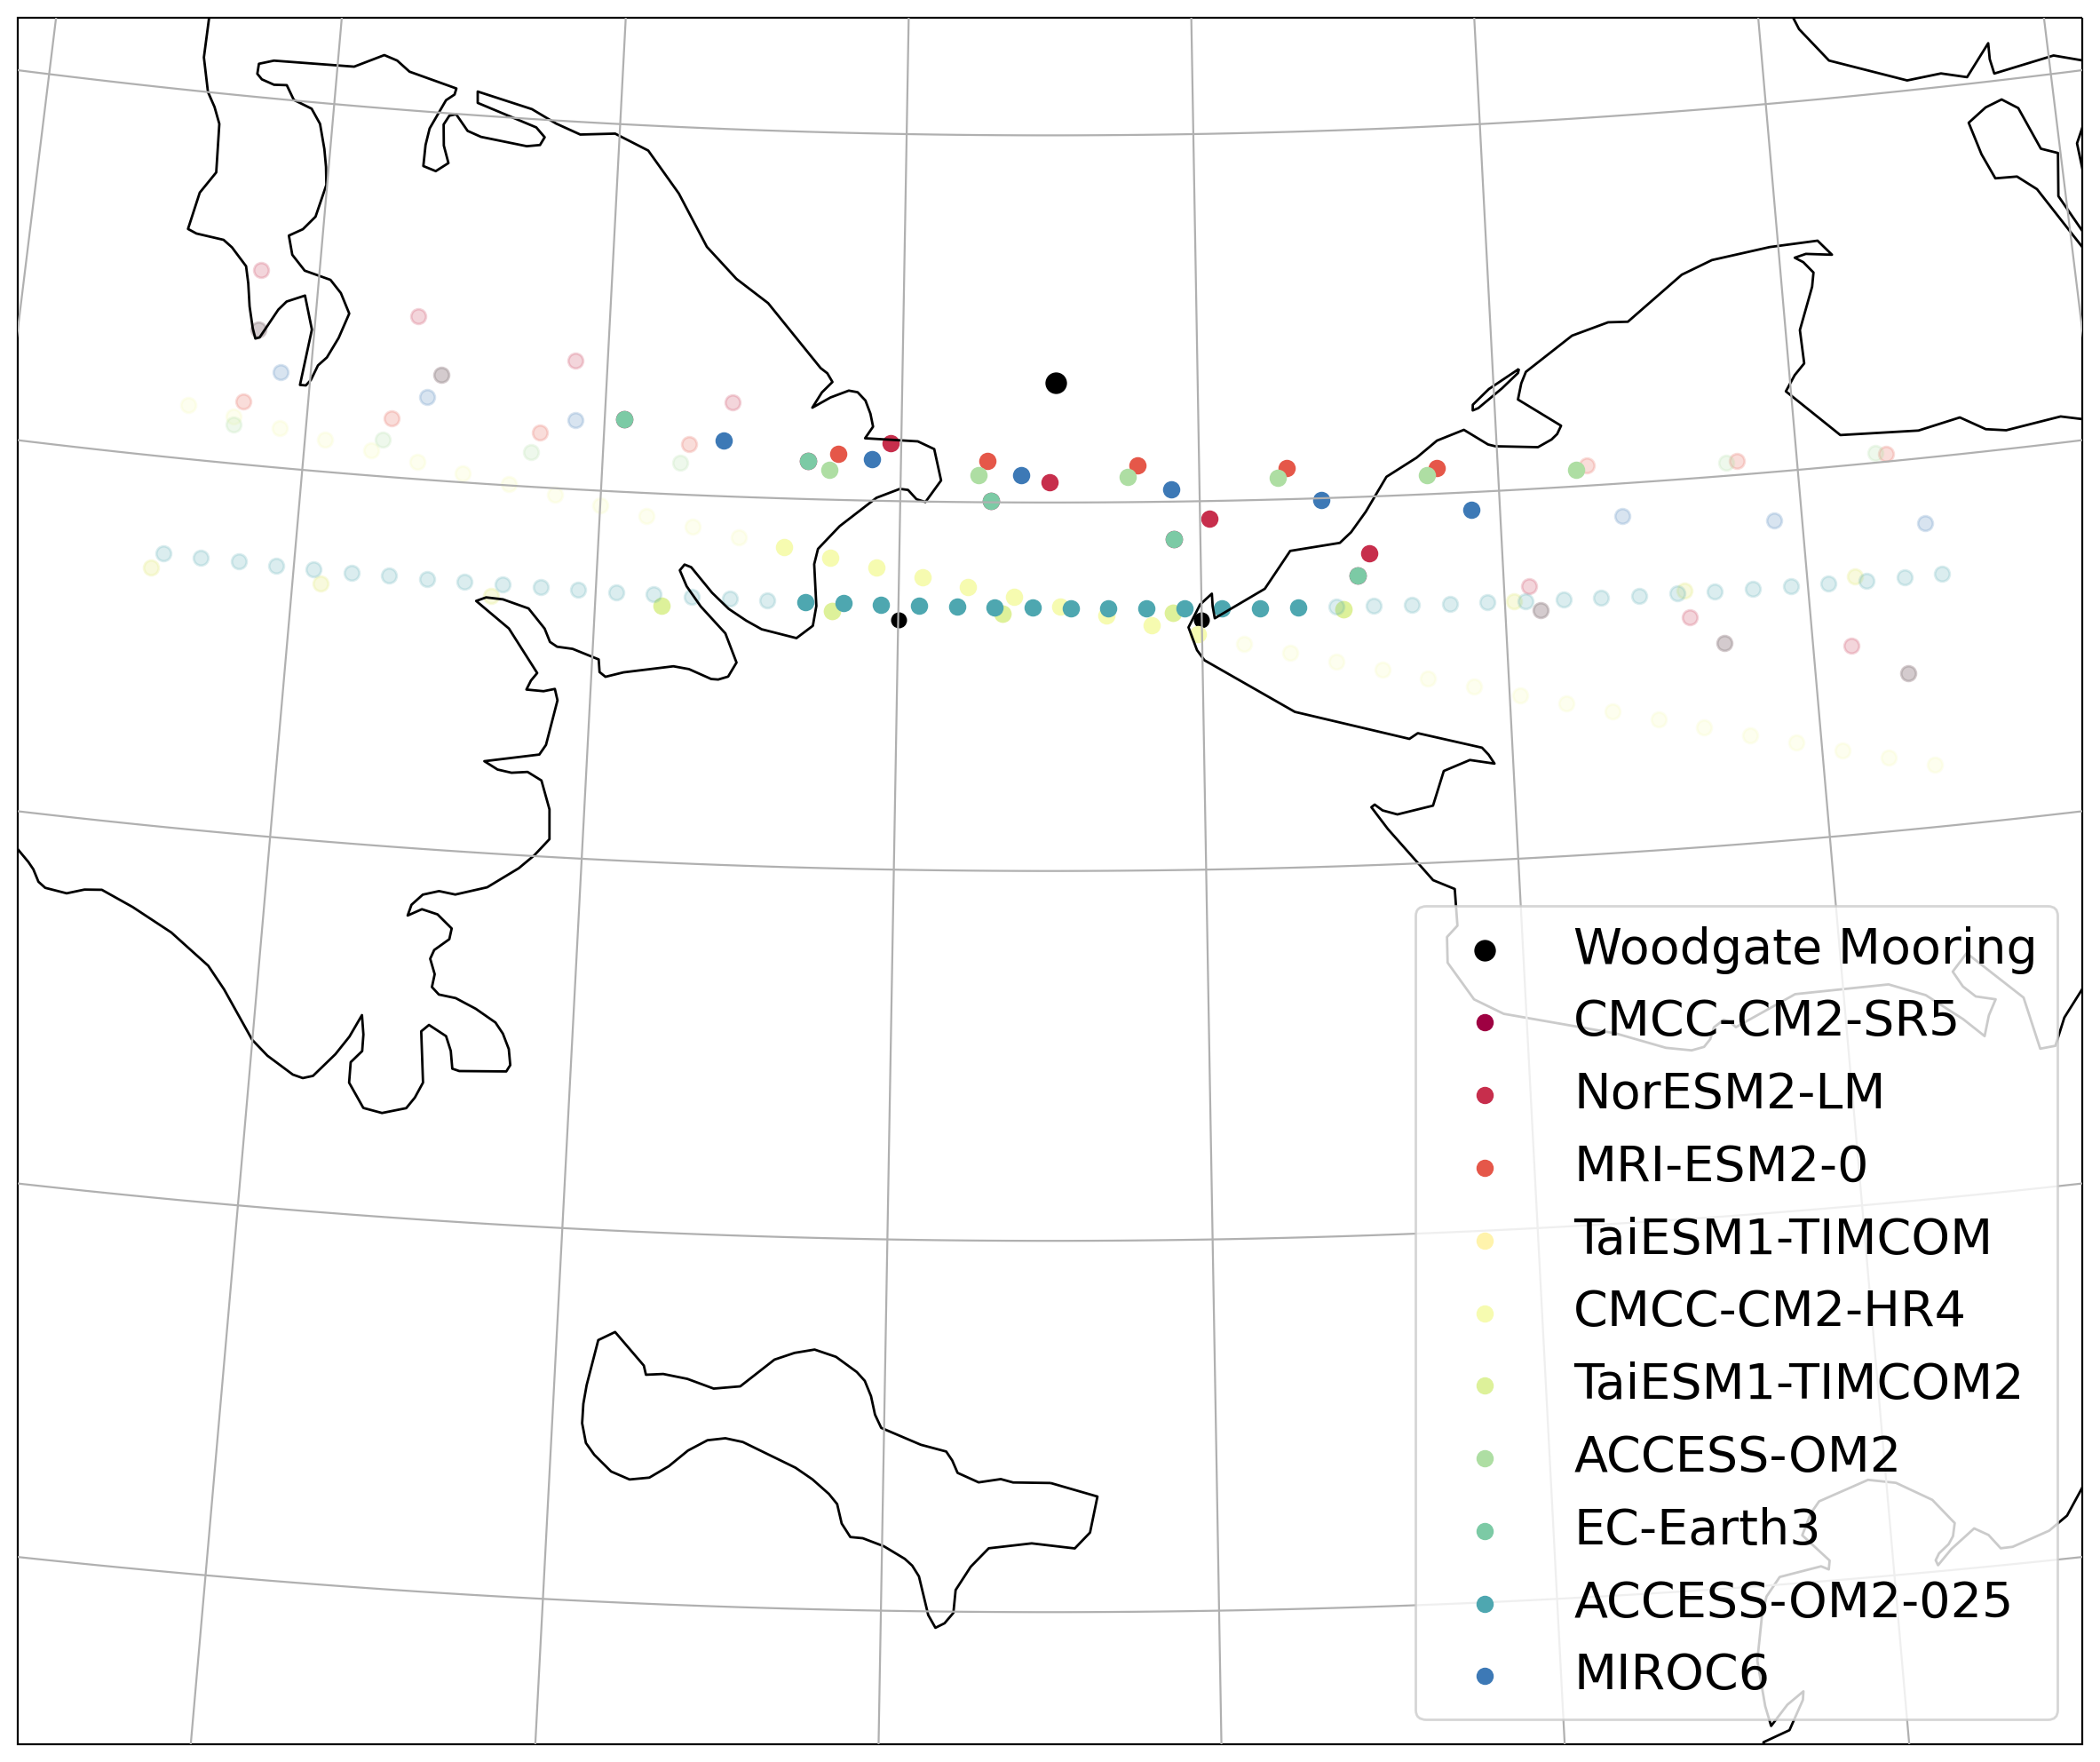

In [96]:
%%time 

## Loop through models and load in file, find lowest index then plot it

#color = plt.cm.Spectral(norm(year))
i=0 

#Method of normalizing model num 
def norm(pval):
    return (pval - 0) / float(len(list(models_fnames_dict_depth.keys())) - 0)

for model in models_fnames_dict_depth : 

    #model = list(model_fnames_dict.keys())[0]

    try : 
        #Load dsnow using load_model_from_esgf_file_in_model_fnames_dict
        dsnow = load_ds_from_esgf_file_in_model_fnames_dict(model, models_fnames_dict_depth, 'True') #model_fnames_dict)


        #Subset by bs 
        cond_bs_lat_i = (dsnow['lat']>=lat_bs_i) & (dsnow['lon']>=bering_minlon) & (dsnow['lon']<=bering_maxlon)
        dsnow_gt_bs_lat_i = dsnow.where(cond_bs_lat_i ,drop=True) #[[var_i]]

        # Subset models by lat index
        dsnow_bs_lat_i_ind = subset_model_by_lat_ind(dsnow_gt_bs_lat_i)

        #print('I made it this far.')
        
        ## Subselect lat by edges of land (depth=0) on either side 
        dsnow_bs_lat_i_ind = dsnow_bs_lat_i_ind.where(dsnow_bs_lat_i_ind.lon>bering_minlon-5, drop=True).where(dsnow_bs_lat_i_ind.lon<bering_maxlon+5, drop=True)
        
        #Mask for where deptho is 0 /nan
        dsnow_bs_lat_i_where0 = (dsnow_bs_lat_i_ind.deptho>0)

        #Find left and right indexes of straight
        ileft = dsnow_bs_lat_i_where0.idxmax().values-1 #search from left for index of first True
        dsnow_bs_lat_i_where0 = dsnow_bs_lat_i_where0.sortby('x', ascending=False)
        iright = dsnow_bs_lat_i_where0.idxmax().values+1 #search from right for index of first True        
        
        print(model, ileft, iright, " IE ", dsnow_bs_lat_i_ind.sel(x=ileft).lon.values, "-", dsnow_bs_lat_i_ind.sel(x=iright).lon.values)
        
        color = plt.cm.Spectral(norm(i))    
        
        if model == list(models_fnames_dict_depth.keys())[0] : 
            #First model so generate plot
            fig, axes = plt.subplots(nrows=1,  ncols=1, figsize=(15,15))
            ax1 = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo(central_longitude=(bs_lons[0]+bs_lons[1])/2))
            #ax1.set_extent([183, 197, 64, 68], ccrs.PlateCarree()) #[160, 210, 50, 80], ccrs.PlateCarree())
            ax1.set_extent([185, 197, 62.5, 67.2], ccrs.PlateCarree())
            ax1.coastlines(resolution='50m',color='black', linewidth=1, zorder=3)
            
            ax1.scatter([180 + (180-168 - 57.5/60)], [66 + (19.6/60)], transform=ccrs.PlateCarree(), c='k', s=60, label='Woodgate Mooring')            
            
            ax1.scatter(dsnow_bs_lat_i_ind.lon, dsnow_bs_lat_i_ind.lat, transform=ccrs.PlateCarree(), label='_'+model, alpha=0.2, color=color)
            ax1.scatter(dsnow_bs_lat_i_ind.sel(x=slice(ileft, iright)).lon, dsnow_bs_lat_i_ind.sel(x=slice(ileft, iright)).lat, transform=ccrs.PlateCarree(), label=model, color=color)
            gl = ax1.gridlines(draw_labels=False, zorder=4)
            ax1.scatter(bs_lons[0], lat_bs_i, transform=ccrs.PlateCarree(), c='k', s=30)
            ax1.scatter(bs_lons[1], lat_bs_i, transform=ccrs.PlateCarree(), c='k', s=30)

            

        elif model == list(models_fnames_dict_depth.keys())[-1] : 
            #Final model (plot legend and save plot)
            ax1 = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo(central_longitude=(bs_lons[0]+bs_lons[1])/2))
            ax1.scatter(dsnow_bs_lat_i_ind.lon, dsnow_bs_lat_i_ind.lat, transform=ccrs.PlateCarree(), label='_'+model, alpha=0.2, color=color)
            ax1.scatter(dsnow_bs_lat_i_ind.sel(x=slice(ileft, iright)).lon, dsnow_bs_lat_i_ind.sel(x=slice(ileft, iright)).lat, transform=ccrs.PlateCarree(), label=model, color=color)
            plt.legend(loc='lower right', fontsize=20)

            #Save fig 
            plt.savefig('../figs/OMIP_xgrid_bering_straight_transect_location.png', dpi=300, transparent=False, bbox_inches='tight', pad_inches=0.1)

        else :    
            ax1 = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo(central_longitude=(bs_lons[0]+bs_lons[1])/2))
            ax1.scatter(dsnow_bs_lat_i_ind.lon, dsnow_bs_lat_i_ind.lat, transform=ccrs.PlateCarree(), label='_'+model, alpha=0.2, color=color)
            ax1.scatter(dsnow_bs_lat_i_ind.sel(x=slice(ileft, iright)).lon, dsnow_bs_lat_i_ind.sel(x=slice(ileft, iright)).lat, transform=ccrs.PlateCarree(), label=model, color=color)
            
            
    except : 
        print("Couldn't load : "+str(model))
    
    i+=1

In [64]:
bering_minlon-20, bering_maxlon+20
#model, ileft, iright

(170, 212)

In [54]:

dsnow_bs_lat_i_ind = dsnow_bs_lat_i_ind.where(dsnow_bs_lat_i_ind.lon>160, drop=True).where(dsnow_bs_lat_i_ind.lon<220, drop=True)

dsnow_bs_lat_i_where0 = (dsnow_bs_lat_i_ind.deptho>0)

ileft = dsnow_bs_lat_i_where0.idxmax().values #search from left for index of first True

dsnow_bs_lat_i_where0 = dsnow_bs_lat_i_where0.sortby('x', ascending=False)

iright = dsnow_bs_lat_i_where0.idxmax().values #search from right for index of first True
#subtract 1 on left, add one on right (or opposite)

#ileft
#np.nanmin(dsnow_bs_lat_i_ind.deptho), np.nanmax(dsnow_bs_lat_i_ind.deptho)
#dsnow_bs_lat_i_ind.deptho.sel(y=dsnow_bs_lat_i_where0.idxmax().values) #, dsnow_bs_lat_i_where0.idxmax().values #

print(dsnow_bs_lat_i_ind.sel(x=dsnow_bs_lat_i_where0.idxmax().values).deptho.values, dsnow_bs_lat_i_where0.idxmax().values) #.x.where(dsnow_bs_lat_i_where0)

dsnow_bs_lat_i_ind.sel(x=dsnow_bs_lat_i_where0.idxmax().values-1).deptho.values, dsnow_bs_lat_i_where0.idxmax().values-1 #.x.where(dsnow_bs_lat_i_where0)

#dsnow_bs_lat_i_where0.idxmax() #.sel(x=slice(120, 140))

ileft, iright

50.0 132.5


(array(129.5), array(132.5))

In [52]:
#model
#model_fnames_dict[model]
#fnames_i #list(model_fnames_dict.keys())[0]


#ds1 = xr.open_dataset(model_fnames_dict[list(model_fnames_dict.keys())[0]][0])
#ds2 = xr.open_dataset(fnames_i[1])

#ds3 = xr.open_dataset(fnames_i[2])
#ds4 = xr.open_dataset(fnames_i[3])

#ds1 = rename_cmip6(ds1)

#ds1, ds2

#np.nanmin(ds1.vertices_latitude) , np.nanmin(ds2.vertices_latitude)
#np.nanmin(ds1.lon), np.nanmax(ds1.lon)

#ds12 = xr.open_mfdataset(fnames_i, combine='by_coords', compat='override')
#ds12

In [53]:
#dsnow

## Testing one model

In [79]:
#Testing "CNRM-CM6-1"

### Set Bering Straight region 

#bering_minlon = 190 #188 #172 #160
#bering_maxlon = 192 #196 #200
##Note that most models are very sensitive to the maxlon value as most of the grids slant that way


#lat_bs_i = 66 + (19.6/60) - 0.5

#bs_lons = [bering_minlon, bering_maxlon]
#bs_lats = [lat_bs_i, lat_bs_i]

model_name_des = "TaiESM1-TIMCOM2"

dsnow = load_ds_from_esgf_file_in_model_fnames_dict(model_name_des, model_fnames_dict, 'True')

#Subset by bs 
cond_bs_lat_i = (dsnow['lat']>=lat_bs_i) & (dsnow['lon']>=bering_minlon) & (dsnow['lon']<=bering_maxlon)
dsnow_gt_bs_lat_i = dsnow.where(cond_bs_lat_i ,drop=True) #[[var_i]]

dsnow_bs_lat_i_ind = subset_model_by_lat_ind(dsnow_gt_bs_lat_i)

dsnow_bs_lat_i_ind

<xarray.Dataset>
Dimensions:        (time: 732, lev: 55, x: 320, bnds: 2, vertex: 4)
Coordinates:
  * time           (time) object 0306-01-16 12:00:00 ... 0366-12-16 12:00:00
    time_bounds    (time, bnds) object dask.array<chunksize=(732, 2), meta=np.ndarray>
  * lev            (lev) float64 5.501 16.7 28.18 ... 5.061e+03 5.542e+03
    lev_bounds     (lev, bnds) float64 dask.array<chunksize=(55, 2), meta=np.ndarray>
    y              int32 263
  * x              (x) int32 0 1 2 3 4 5 6 7 ... 312 313 314 315 316 317 318 319
    lat_verticies  (x, vertex) float64 dask.array<chunksize=(320, 4), meta=np.ndarray>
    lon_verticies  (x, vertex) float64 dask.array<chunksize=(320, 4), meta=np.ndarray>
    lat            (x) float64 dask.array<chunksize=(320,), meta=np.ndarray>
    lon            (x) float64 dask.array<chunksize=(320,), meta=np.ndarray>
    lon_bounds     (bnds, x) float64 dask.array<chunksize=(1, 320), meta=np.ndarray>
    lat_bounds     (bnds, x) float64 dask.array<chunksize=(1, 320), meta=np.ndarray>
Dimensions without coordinates: bnds, vertex
Data variables:
    so             (time, lev, x) float32 dask.array<chunksize=(732, 55, 320), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     OMIP
    branch_method:                   no parent
    contact:                         Dr. Yu-Heng Tseng (tsengyh@ntu.edu.tw)
    creation_date:                   2021-12-15T07:47:07Z
    data_specs_version:              01.00.33
    ...                              ...
    variable_id:                     so
    variant_label:                   r1i1p1f1
    license:                         CMIP6 model data produced by REQUIRED is...
    cmor_version:                    3.5.0
    tracking_id:                     hdl:21.14100/37b45ca4-b20f-47bb-9ea0-509...
    DODS_EXTRA.Unlimited_Dimension:  time

In [80]:
yind1 = dsnow_gt_bs_lat_i.lat.isel(y=0).y.values
yind2 = dsnow_gt_bs_lat_i.lat.isel(y=-1).y.values
xind1 = dsnow_gt_bs_lat_i.lat.isel(x=0).x.values
xind2 = dsnow_gt_bs_lat_i.lat.isel(x=-1).x.values

y1_ind_diff = np.nanmax(dsnow_gt_bs_lat_i.lat.sel(y=yind1).values)-np.nanmin(dsnow_gt_bs_lat_i.lat.sel(y=yind1).values)
y2_ind_diff = np.nanmax(dsnow_gt_bs_lat_i.lat.sel(y=yind2).values)-np.nanmin(dsnow_gt_bs_lat_i.lat.sel(y=yind2).values)

x1_ind_diff = np.nanmax(dsnow_gt_bs_lat_i.lat.sel(x=xind1).values)-np.nanmin(dsnow_gt_bs_lat_i.lat.sel(x=xind1).values)
x2_ind_diff = np.nanmax(dsnow_gt_bs_lat_i.lat.sel(x=xind2).values)-np.nanmin(dsnow_gt_bs_lat_i.lat.sel(x=xind2).values)

dsnow_gt_bs_lat_i.lat.isel(y=0).y.values - (dsnow_gt_bs_lat_i.lat.isel(y=1).y.values-dsnow_gt_bs_lat_i.lat.isel(y=0).y.values)
#yind1, yind2, #xind1, xind2 #np.nanmin(dsnow_gt_bs_lat_i.lat.sel(y=yind1).values)

262

In [56]:
dsnow_gt_bs_lat_i #.isel(x=0).lat.values #.sel(y=66.47, method='nearest').lat.values
#dsnow.isel(y=0).lat.values

<xarray.Dataset>
Dimensions:        (time: 732, lev: 55, y: 25, x: 2, bnds: 2, vertex: 4)
Coordinates: (12/14)
  * time           (time) object 0306-01-16 12:00:00 ... 0366-12-16 12:00:00
    time_bounds    (time, bnds) object dask.array<chunksize=(732, 2), meta=np.ndarray>
  * lev            (lev) float64 5.501 16.7 28.18 ... 5.061e+03 5.542e+03
    lev_bounds     (lev, bnds) float64 dask.array<chunksize=(55, 2), meta=np.ndarray>
  * y              (y) float64 65.7 66.47 67.25 68.03 ... 83.79 84.67 85.56
  * x              (x) float64 190.7 191.8
    ...             ...
    lat            (y, x) float64 dask.array<chunksize=(25, 2), meta=np.ndarray>
    lon            (y, x) float64 dask.array<chunksize=(25, 2), meta=np.ndarray>
  * bnds           (bnds) int64 0 1
  * vertex         (vertex) int64 0 1 2 3
    lon_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 25, 2), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 25, 2), meta=np.ndarray>
Data variables:
    so             (time, lev, y, x) float32 dask.array<chunksize=(732, 55, 25, 2), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     OMIP
    branch_method:                   no parent
    contact:                         Dr. Yu-Heng Tseng (tsengyh@ntu.edu.tw)
    creation_date:                   2021-12-15T07:47:07Z
    data_specs_version:              01.00.33
    ...                              ...
    variable_id:                     so
    variant_label:                   r1i1p1f1
    license:                         CMIP6 model data produced by REQUIRED is...
    cmor_version:                    3.5.0
    tracking_id:                     hdl:21.14100/37b45ca4-b20f-47bb-9ea0-509...
    DODS_EXTRA.Unlimited_Dimension:  time

In [57]:
dsnow_gt_bs_lat_i.lat.values, dsnow_gt_bs_lat_i.lon.values

(array([[65.69691243, 65.69691243],
        [66.46869684, 66.46869684],
        [67.24511196, 67.24511196],
        [68.02618557, 68.02618557],
        [68.81194562, 68.81194562],
        [69.60242023, 69.60242023],
        [70.39763769, 70.39763769],
        [71.19762646, 71.19762646],
        [72.00241515, 72.00241515],
        [72.81203258, 72.81203258],
        [73.62650771, 73.62650771],
        [74.4458697 , 74.4458697 ],
        [75.27014785, 75.27014785],
        [76.09937168, 76.09937168],
        [76.93357084, 76.93357084],
        [77.77277521, 77.77277521],
        [78.6170148 , 78.6170148 ],
        [79.46631982, 79.46631982],
        [80.32072068, 80.32072068],
        [81.18024794, 81.18024794],
        [82.04493236, 82.04493236],
        [82.9148049 , 82.9148049 ],
        [83.78989666, 83.78989666],
        [84.67023898, 84.67023898],
        [85.55586335, 85.55586335]]),
 array([[190.6875, 191.8125],
        [190.6875, 191.8125],
        [190.6875, 191.8125],
        

In [58]:
dsnow_gt_bs_lat_i.isel(time=0).isel(lev=0).so.values #.plot()

<xarray.DataArray 'so' (y: 25, x: 2)>
dask.array<getitem, shape=(25, 2), dtype=float32, chunksize=(25, 2), chunktype=numpy.ndarray>
Coordinates:
    time     object 0306-01-16 12:00:00
    lev      float64 5.501
  * y        (y) float64 65.7 66.47 67.25 68.03 ... 82.91 83.79 84.67 85.56
  * x        (x) float64 190.7 191.8
    lat      (y, x) float64 dask.array<chunksize=(25, 2), meta=np.ndarray>
    lon      (y, x) float64 dask.array<chunksize=(25, 2), meta=np.ndarray>
Attributes:
    standard_name:  sea_water_salinity
    long_name:      Sea Water Salinity
    comment:        Sea water salinity is the salt content of sea water, ofte...
    units:          0.001
    original_name:  so
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello volume: volcello
    _ChunkSizes:    [  1  28 144 160]

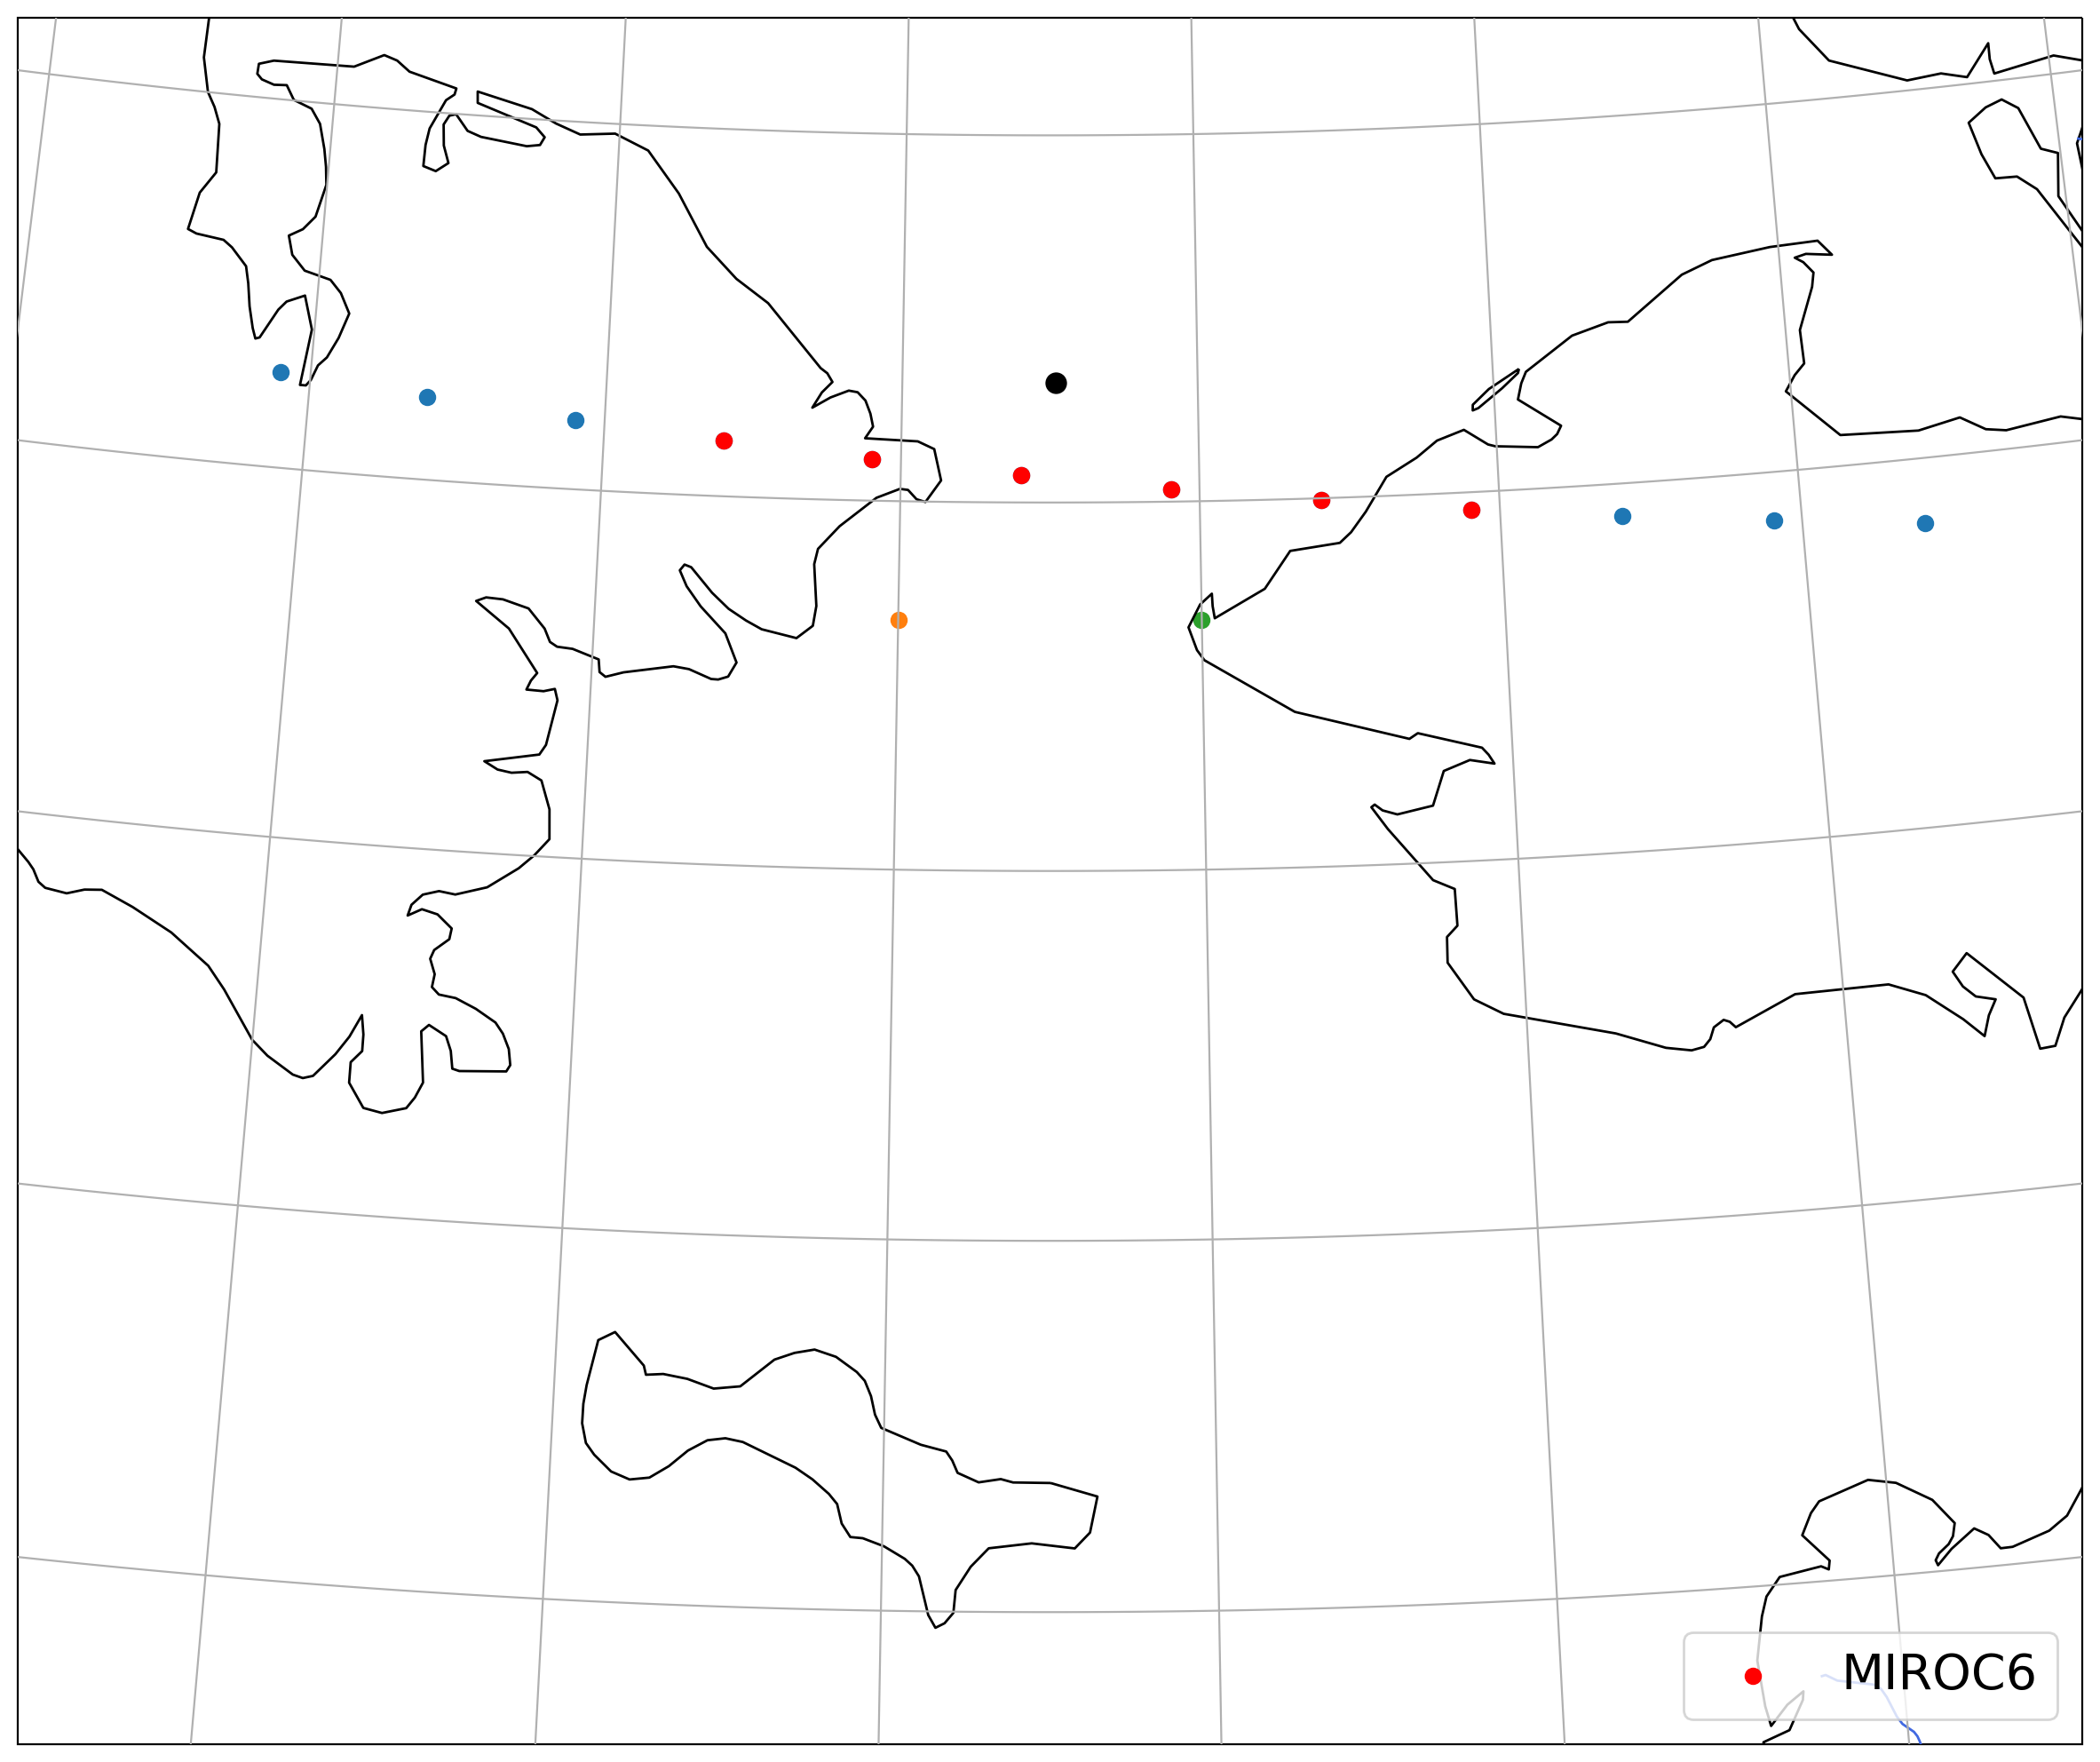

In [95]:
fig, axes = plt.subplots(nrows=1,  ncols=1, figsize=(15,15))
ax1 = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo(central_longitude=(bs_lons[0]+bs_lons[1])/2))

#ax1.set_extent([185, 195, 64, 68], ccrs.PlateCarree()) #[160, 210, 50, 80], ccrs.PlateCarree())
#ax1.set_extent([182, 200, 64, 68], ccrs.PlateCarree()) #[160, 210, 50, 80], ccrs.PlateCarree())
ax1.set_extent([185, 197, 62.5, 67.2], ccrs.PlateCarree())

ax1.coastlines(resolution='50m',color='black', linewidth=1, zorder=3)
#ax1.add_feature(cartopy.feature.LAND, facecolor='lightgrey', zorder=2)


ax1.scatter(dsnow_bs_lat_i_ind.lon, dsnow_bs_lat_i_ind.lat, transform=ccrs.PlateCarree())
ax1.add_feature(cartopy.feature.RIVERS, edgecolor='royalblue', zorder=3)


ax1.scatter(dsnow_bs_lat_i_ind.lon.sel(x=slice(ileft, iright)), dsnow_bs_lat_i_ind.lat.sel(x=slice(ileft, iright)), transform=ccrs.PlateCarree(), label=model, c='r')

#if len(dsnow_bs_trans_j.lon)>1 : 
#    ax1.scatter(dsnow_bs_trans_j.lon, dsnow_bs_trans_j.lat, transform=ccrs.PlateCarree()) #scatter
#else : 
#    ax1.scatter(dsnow_bs_trans_j.lon, np.ones(len(dsnow_bs_trans_j.lon))*dsnow_bs_trans_j.lat.values, transform=ccrs.PlateCarree()) #scatter

gl = ax1.gridlines(draw_labels=False, zorder=4)
ax1.scatter(bs_lons[0], lat_bs_i, transform=ccrs.PlateCarree())
ax1.scatter(bs_lons[1], lat_bs_i, transform=ccrs.PlateCarree())

ax1.scatter([180 + (180-168 - 57.5/60)], [66 + (19.6/60)], transform=ccrs.PlateCarree(), c='k', s=60)

plt.legend(loc='lower right', fontsize=20)
#ax1.pcolormesh()

#dsnow_bs.so.plot()

In [85]:
dsnow_bs_lat_i_ind.so #.values
#dsnow_bs_lat_i_ind.where(dsnow_bs_lat_i_ind.lon>160, drop=True).where(dsnow_bs_lat_i_ind.lon<220, drop=True) #.sel(lon=slice(160, 220)) #.lon.values

<xarray.DataArray 'so' (time: 732, lev: 55, x: 320)>
dask.array<getitem, shape=(732, 55, 320), dtype=float32, chunksize=(732, 55, 320), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0306-01-16 12:00:00 ... 0366-12-16 12:00:00
  * lev      (lev) float64 5.501 16.7 28.18 ... 4.624e+03 5.061e+03 5.542e+03
    y        int32 263
  * x        (x) int32 0 1 2 3 4 5 6 7 8 ... 311 312 313 314 315 316 317 318 319
    lat      (x) float64 dask.array<chunksize=(320,), meta=np.ndarray>
    lon      (x) float64 dask.array<chunksize=(320,), meta=np.ndarray>
Attributes:
    standard_name:  sea_water_salinity
    long_name:      Sea Water Salinity
    comment:        Sea water salinity is the salt content of sea water, ofte...
    original_name:  so
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello volume: volcello
    _ChunkSizes:    [  1  28 144 160]

In [60]:
#dsnow.where((dsnow['lon']>=bering_minlon), drop=True) #& (dsnow['lon']>=bering_minlon) & (dsnow['lon']<=bering_maxlon)
#np.nanmin(dsnow.lon), np.nanmax(dsnow.lon)
#np.nanmax(dsnow.lat.values) #_gt_bs_lat_i
lat_bs_i

65.67666666666666

## Old Code

In [72]:
def xmip_preproc(ds_i) : 

    #Sort out coords with xmip
    ds_i = xmip.rename_cmip6(ds_i)
    ds_i = xmip.promote_empty_dims(ds_i)
    ds_i = xmip.broadcast_lonlat(ds_i)
    ds_i = xmip.correct_lon(ds_i)
    ds_i = xmip.replace_x_y_nominal_lat_lon(ds_i)
    ds_i = xmip.correct_coordinates(ds_i)
    ds_i = xmip.parse_lon_lat_bounds(ds_i)
    ds_i = xmip.maybe_convert_bounds_to_vertex(ds_i)
    ds_i = xmip.maybe_convert_vertex_to_bounds(ds_i)

    return(ds_i)

In [1]:
def load_1file_ds_from_esgf_file_in_model_fnames_dict(model, model_fnames_dict) : 
    
    ## Generate filename from model_fnames_dict
    fnames_i = model_fnames_dict[model]
    
    fnames_i_2d = [fnames_i[0]]

    # Open filenames
    ds_i = xr.open_mfdataset(fnames_i_2d, combine='by_coords', compat='override', preprocess=xmip_preproc)

    ##Sort out coords with xmip
    #ds_i = xmip.rename_cmip6(ds_i)
    #ds_i = xmip.promote_empty_dims(ds_i)
    #ds_i = xmip.broadcast_lonlat(ds_i)
    #ds_i = xmip.correct_lon(ds_i)
    #ds_i = xmip.replace_x_y_nominal_lat_lon(ds_i)
    #ds_i = xmip.correct_coordinates(ds_i)
    #ds_i = xmip.parse_lon_lat_bounds(ds_i)
    #ds_i = xmip.maybe_convert_bounds_to_vertex(ds_i)
    #ds_i = xmip.maybe_convert_vertex_to_bounds(ds_i)
    
    
    ##Make lat and lon coords not vars
    #ds_i = ds_i.assign_coords({'lon':ds_i.lon, 'lat':ds_i.lat})
    
    ##Sort by lon 
    #ds_i = ds_i.sortby('lon')

    ## Subset by >50N
    cond_i = (ds_i['lat']>=50)
    dsnow = ds_i.where(cond_i,drop=True) #[[var_i]]
    
    
    return(dsnow)

In [63]:
def load_ds_from_esgf_file_in_model_fnames_dict(model, model_fnames_dict) : 
    
    ## Generate filename from model_fnames_dict
    fnames_i = model_fnames_dict[model]

    # Open filenames
    ds_i = xr.open_mfdataset(fnames_i, combine='by_coords', compat='override', preprocess=xmip_preproc)

    ##Sort out coords with xmip
    #ds_i = xmip.rename_cmip6(ds_i)
    #ds_i = xmip.promote_empty_dims(ds_i)
    #ds_i = xmip.broadcast_lonlat(ds_i)
    #ds_i = xmip.correct_lon(ds_i)
    #ds_i = xmip.replace_x_y_nominal_lat_lon(ds_i)
    #ds_i = xmip.correct_coordinates(ds_i)
    #ds_i = xmip.parse_lon_lat_bounds(ds_i)
    #ds_i = xmip.maybe_convert_bounds_to_vertex(ds_i)
    #ds_i = xmip.maybe_convert_vertex_to_bounds(ds_i)
    
    
    ##Make lat and lon coords not vars
    #ds_i = ds_i.assign_coords({'lon':ds_i.lon, 'lat':ds_i.lat})
    
    ##Sort by lon 
    #ds_i = ds_i.sortby('lon')

    ## Subset by >50N
    cond_i = (ds_i['lat']>=50)
    dsnow = ds_i.where(cond_i,drop=True) #[[var_i]]
    
    
    return(dsnow)

In [61]:
%%time 

## Loop through models and load in file, find lowest index then plot it

for model in model_fnames_dict : 
    print(model)

    #model = list(model_fnames_dict.keys())[0]

    try : 
        #Load dsnow using load_model_from_esgf_file_in_model_fnames_dict
        dsnow = load_model_from_esgf_file_in_model_fnames_dict(model, model_fnames_dict)

        ### Generate filename from model_fnames_dict
        #fnames_i = model_fnames_dict[model]
        ## Open filenames
        #ds_i = xr.open_mfdataset(fnames_i, combine='by_coords', compat='override')
        ##Sort out coords with xmip
        #ds_i = rename_cmip6(ds_i)
        ##Make lat and lon coords not vars
        #ds_i = ds_i.assign_coords({'lon':ds_i.lon, 'lat':ds_i.lat})
        ### Subset by >50N
        #cond_i = (ds_i['lat']>=50)
        #dsnow = ds_i.where(cond_i,drop=True) #[[var_i]]

        #Subset by bs 
        cond_bs_lat_i = (dsnow['lat']>=lat_bs_i) & (dsnow['lon']>=bering_minlon) & (dsnow['lon']<=bering_maxlon)
        dsnow_gt_bs_lat_i = dsnow.where(cond_bs_lat_i ,drop=True) #[[var_i]]

        
        dsnow_bs_lat_i_ind = subset_model_by_lat_ind(dsnow_gt_bs_lat_i)
        ##Calc all min and max x and y indexes
        #yind1 = dsnow_gt_bs_lat_i.lat.isel(y=0).y.values
        #yind2 = dsnow_gt_bs_lat_i.lat.isel(y=-1).y.values
        #xind1 = dsnow_gt_bs_lat_i.lat.isel(x=0).x.values
        #xind2 = dsnow_gt_bs_lat_i.lat.isel(x=-1).x.values

        ### Determine if x or y index corresponds to lat and if min or max index corresponds to lat

        #y1_ind_diff = np.nanmax(dsnow_gt_bs_lat_i.lat.sel(y=yind1).values)-np.nanmin(dsnow_gt_bs_lat_i.lat.sel(y=yind1).values)
        #y2_ind_diff = np.nanmax(dsnow_gt_bs_lat_i.lat.sel(y=yind2).values)-np.nanmin(dsnow_gt_bs_lat_i.lat.sel(y=yind2).values)

        #x1_ind_diff = np.nanmax(dsnow_gt_bs_lat_i.lat.sel(x=xind1).values)-np.nanmin(dsnow_gt_bs_lat_i.lat.sel(x=xind1).values)
        #x2_ind_diff = np.nanmax(dsnow_gt_bs_lat_i.lat.sel(x=xind2).values)-np.nanmin(dsnow_gt_bs_lat_i.lat.sel(x=xind2).values)

        ## First test if lat range corresponding to xind or yind max-min is bigger
        #if (y1_ind_diff < x1_ind_diff) & (y2_ind_diff < x2_ind_diff)  : 
        #    # If true then y ind corresponds to determining lat 
        #    # Ideally should test this for both x1 and x2 BUT should be same

        #    #Test if y1 or y2 corresponds to min lat
        #    if np.nanmin(dsnow_gt_bs_lat_i.lat.sel(y=yind1).values) <= np.nanmin(dsnow_gt_bs_lat_i.lat.sel(y=yind2).values) : 
        #        dsnow_bs_lat_i_ind = dsnow_gt_bs_lat_i.sel(y=yind1)

         #   else : 
         #       print("y2 > y1")
         #       dsnow_bs_lat_i_ind = dsnow_gt_bs_lat_i.sel(y=yind2)


        #elif (y1_ind_diff > x1_ind_diff) & (y2_ind_diff > x2_ind_diff)  : 
        #    # If True then x ind corresponds to determining lat
        #    print('Note : x ind seems to correspond to lat not y (as expected)!')

         #   #Test if y1 or y2 corresponds to min lat
         #   if np.nanmin(dsnow_gt_bs_lat_i.lat.sel(x=xind1).values) < np.nanmin(dsnow_gt_bs_lat_i.lat.sel(x=xind2).values) : 
         #       dsnow_bs_lat_i_ind = dsnow_gt_bs_lat_i.sel(x=xind1)

          #  else : 
          #      print("y2 > y1")
          #      dsnow_bs_lat_i_ind = dsnow_gt_bs_lat_i.sel(x=xind2)

        #else : 
        #    print("Something weird is going on - check what is happening. x1_ind_diff is : "+str(x1_ind_diff)+", x2_ind_diff is : "+str(x2_ind_diff)+"y1_ind_diff is : "+str(y1_ind_diff)+", y2_ind_diff is : "+str(y2_ind_diff))



        if model == list(model_fnames_dict.keys())[0] : 
            #First model so generate plot
            fig, axes = plt.subplots(nrows=1,  ncols=1, figsize=(15,15))
            ax1 = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo(central_longitude=(bs_lons[0]+bs_lons[1])/2))
            ax1.set_extent([185, 195, 64, 68], ccrs.PlateCarree()) #[160, 210, 50, 80], ccrs.PlateCarree())
            ax1.coastlines(resolution='50m',color='black', linewidth=1, zorder=3)
            ax1.scatter(dsnow_bs_lat_i_ind.lon, dsnow_bs_lat_i_ind.lat, transform=ccrs.PlateCarree(), label=model)
            gl = ax1.gridlines(draw_labels=False, zorder=4)
            ax1.scatter(bs_lons[0], lat_bs_i, transform=ccrs.PlateCarree(), c='k', s=60)
            ax1.scatter(bs_lons[1], lat_bs_i, transform=ccrs.PlateCarree(), c='k', s=60)

        elif model == list(model_fnames_dict.keys())[-1] : 
            #Final model (plot legend and save plot)
            ax1 = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo(central_longitude=(bs_lons[0]+bs_lons[1])/2))
            ax1.scatter(dsnow_bs_lat_i_ind.lon, dsnow_bs_lat_i_ind.lat, transform=ccrs.PlateCarree(), label=model)        
            plt.legend()

            #Save fig 

        else :    
            ax1 = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo(central_longitude=(bs_lons[0]+bs_lons[1])/2))
            ax1.scatter(dsnow_bs_lat_i_ind.lon, dsnow_bs_lat_i_ind.lat, transform=ccrs.PlateCarree(), label=model)

    except : 
        print("Couldn't load : "+str(model))

CMCC-CM2-SR5
Couldn't load : CMCC-CM2-SR5
NorESM2-LM
Couldn't load : NorESM2-LM
MRI-ESM2-0
Couldn't load : MRI-ESM2-0
CNRM-CM6-1
Couldn't load : CNRM-CM6-1
FGOALS-f3-L
Couldn't load : FGOALS-f3-L
CNRM-CM6-1-HR
Couldn't load : CNRM-CM6-1-HR
TaiESM1-TIMCOM
Couldn't load : TaiESM1-TIMCOM
CMCC-CM2-HR4
Couldn't load : CMCC-CM2-HR4
TaiESM1-TIMCOM2
Couldn't load : TaiESM1-TIMCOM2
ACCESS-OM2
Couldn't load : ACCESS-OM2
EC-Earth3
Couldn't load : EC-Earth3
ACCESS-OM2-025
Couldn't load : ACCESS-OM2-025
MIROC6
Couldn't load : MIROC6
CPU times: user 359 µs, sys: 50 µs, total: 409 µs
Wall time: 128 µs
